In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 42

2023-01-14 09:18:08.319098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 09:18:24.138106: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 09:19:03.602167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-14 09:19:03.602662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [27]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        
    
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test, task):
        self.x_test = x_test
        self.y_test = y_test
        self.task = task

    def on_epoch_end(self, epoch, logs):        
        if self.task == "classification":
            loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_accuracy'] = acc
            logs["test_loss"] = loss
        if self.task == "regression":
            mse_test, mee_test = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            logs['test_mse'] = mse_test
            logs["test_mee"] = mee_test


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        if init != None:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg))

        
        
    if task == "classification":
        
        if init != None:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        
        if init != None:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer = init))
        else:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} mean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_val_loss = np.mean(trials_val_loss)
    med_train_loss = np.mean(trials_train_loss)
    med_val_acc = np.mean(trials_val_acc)
    med_train_acc = np.mean(trials_train_acc)
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMean val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Mean train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Mean {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Mean train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, x_test, y_test, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
        test_metric = "test_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        test_metric = "test_mee"
    val_loss = "val_mse"
    train_loss = "mse"
    test_loss = "test_mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    callbacks.append(TestCallback(x_test, y_test, task))
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    trials_test_acc = []
    trials_test_loss = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    trials_history_test_acc = []
    trials_history_test_loss = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)
            
            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_test_loss = history.history["test_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            trial_test_acc = history.history[test_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_loss.append(trial_test_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            trials_test_acc.append(trial_test_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_loss.append(trial_test_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            trials_history_test_acc.append(trial_test_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_loss}: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")
            # print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    if task == "regression":
    
        y_pred = med_model.predict(x_val)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)


        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    return med_model    
    

def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, x_test, y_test, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, x_test, y_test, best_conf)
        
    return model

# Monks 1

In [5]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [9]:
'''params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 5,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.5, 0.8],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.1, 0.5, 0.8],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}'''


params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 1/4 mean val_loss: 0.0017250098753720522, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0002660175960045308, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.86s/it]


Fold 2/4 mean val_loss: 0.043050553649663925, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0002951947972178459, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 3/4 mean val_loss: 0.0002726333914324641, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00018493563402444124, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.85s/it]


Fold 4/4 mean val_loss: 0.001736205886118114, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00018526901840232313, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011696100700646639, std val_loss: 0.01811228507159692
Mean train_loss: 0.00023285426141228527, std train_loss: 4.88536062355017e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


Fold 1/4 mean val_loss: 0.0014847326092422009, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0001457393227610737, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.65s/it]


Fold 2/4 mean val_loss: 0.0013035297160968184, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00014132286014501005, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Fold 3/4 mean val_loss: 0.0003617746406234801, std val_loss 0.0
Fold 3/4 mean train_loss: 9.445841715205461e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 4/4 mean val_loss: 0.2800542712211609, std val_loss 0.0
Fold 4/4 mean train_loss: 0.08572223782539368, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.6451612710952759, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9139785170555115, train_accuracy 0.0

Mean val_loss: 0.07080107704678085, std val_loss: 0.12081314010364419
Mean train_loss: 0.021525939606362954, std train_loss: 0.037063755505007116
Mean val_accuracy: 0.911290317773819, std val_accuracy: 0.15364967673903535
Mean train_accuracy: 0.911290317773819, std train_accuracy: 0.03724839475056844



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.12s/it]


Fold 1/4 mean val_loss: 0.05254553630948067, std val_loss 0.0
Fold 1/4 mean train_loss: 7.239779370138422e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


Fold 2/4 mean val_loss: 9.541141480440274e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 5.1181752496631816e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.71s/it]


Fold 3/4 mean val_loss: 0.006925585679709911, std val_loss 0.0
Fold 3/4 mean train_loss: 7.091415318427607e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 4/4 mean val_loss: 0.005090504419058561, std val_loss 0.0
Fold 4/4 mean train_loss: 5.36747720616404e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.016164259455763386, std val_loss: 0.021152933169087566
Mean train_loss: 6.204211786098313e-05, std train_loss: 9.668415646606798e-06
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Fold 1/4 mean val_loss: 0.001481477404013276, std val_loss 0.0
Fold 1/4 mean train_loss: 2.0781484636245295e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Fold 2/4 mean val_loss: 0.00018391128105577081, std val_loss 0.0
Fold 2/4 mean train_loss: 5.719848923035897e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Fold 3/4 mean val_loss: 0.059511009603738785, std val_loss 0.0
Fold 3/4 mean train_loss: 2.5374034521519206e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Fold 4/4 mean val_loss: 0.21796251833438873, std val_loss 0.0
Fold 4/4 mean train_loss: 0.02692391723394394, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.06978472915579914, std val_loss: 0.08884229646962921
Mean train_loss: 0.006756817810583016, std train_loss: 0.0116434887265106
Mean val_accuracy: 0.9193548411130905, std val_accuracy: 0.10576513433669522
Mean train_accuracy: 0.9193548411130905, std train_accuracy: 0.01396816416244334



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.17s/it]


Fold 1/4 mean val_loss: 0.0011583770392462611, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00013204450078774244, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Fold 2/4 mean val_loss: 0.00585560780018568, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00012998914462514222, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Fold 3/4 mean val_loss: 0.053661003708839417, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0007938465569168329, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.84s/it]


Fold 4/4 mean val_loss: 0.10829656571149826, std val_loss 0.0
Fold 4/4 mean train_loss: 0.05417201668024063, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9462365508079529, train_accuracy 0.0

Mean val_loss: 0.042242888564942405, std val_loss: 0.04331695080098269
Mean train_loss: 0.013806974220642587, std train_loss: 0.02330633909460123
Mean val_accuracy: 0.9516129046678543, std val_accuracy: 0.053493946637294815
Mean train_accuracy: 0.9516129046678543, std train_accuracy: 0.023280256397693377



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.72s/it]


Fold 1/4 mean val_loss: 0.006028773263096809, std val_loss 0.0
Fold 1/4 mean train_loss: 8.665989298606291e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Fold 2/4 mean val_loss: 0.002323826076462865, std val_loss 0.0
Fold 2/4 mean train_loss: 8.481826807837933e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.95s/it]


Fold 3/4 mean val_loss: 0.040117885917425156, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011175538384122774, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Fold 4/4 mean val_loss: 0.0004035548772662878, std val_loss 0.0
Fold 4/4 mean train_loss: 9.140088513959199e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.01221851003356278, std val_loss: 0.016234114943175122
Mean train_loss: 9.36586075113155e-05, std train_loss: 1.0720590353825675e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Fold 1/4 mean val_loss: 0.1837870478630066, std val_loss 0.0
Fold 1/4 mean train_loss: 0.0317237488925457, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9784946441650391, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 2/4 mean val_loss: 0.00012942896864842623, std val_loss 0.0
Fold 2/4 mean train_loss: 6.60749283269979e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Fold 3/4 mean val_loss: 0.0037259175442159176, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011400235234759748, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Fold 4/4 mean val_loss: 0.0749363973736763, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0001101312882383354, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06564469793738681, std val_loss: 0.07444819735525131
Mean train_loss: 0.008003489365364658, std train_loss: 0.01369491116295043
Mean val_accuracy: 0.9193548262119293, std val_accuracy: 0.09265424644296927
Mean train_accuracy: 0.9193548262119293, std train_accuracy: 0.00931209223525004



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.35s/it]


Fold 1/4 mean val_loss: 0.09738705307245255, std val_loss 0.0
Fold 1/4 mean train_loss: 0.01081135030835867, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9892473220825195, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]


Fold 2/4 mean val_loss: 0.04146838188171387, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0006531337276101112, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Fold 3/4 mean val_loss: 0.01982751116156578, std val_loss 0.0
Fold 3/4 mean train_loss: 4.786519275512546e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Fold 4/4 mean val_loss: 0.0012937473366037011, std val_loss 0.0
Fold 4/4 mean train_loss: 1.911618164740503e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.039994173363083974, std val_loss: 0.03605736114537386
Mean train_loss: 0.0028828663525928278, std train_loss: 0.004584508207911175
Mean val_accuracy: 0.9596773982048035, std val_accuracy: 0.03515241833378536
Mean train_accuracy: 0.9596773982048035, std train_accuracy: 0.00465604611762502



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4

100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Fold 1/4 mean val_loss: 0.0003264212282374501, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00010705140448408201, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.91s/it]


Fold 2/4 mean val_loss: 0.012450513429939747, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0001278339623240754, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Fold 3/4 mean val_loss: 0.012139441445469856, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00019063387298956513, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Fold 4/4 mean val_loss: 0.16149941086769104, std val_loss 0.0
Fold 4/4 mean train_loss: 0.03233453258872032, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.04660394674283452, std val_loss: 0.06651472802445862
Mean train_loss: 0.008190012957129511, std train_loss: 0.013939878869433155
Mean val_accuracy: 0.9516128897666931, std val_accuracy: 0.06650171249927743
Mean train_accuracy: 0.9516128897666931, std train_accuracy: 0.01396816416244334



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Fold 1/4 mean val_loss: 0.0014220093144103885, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00016106107796076685, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 2/4 mean val_loss: 0.0011194561375305057, std val_loss 0.0
Fold 2/4 mean train_loss: 8.031161269173026e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Fold 3/4 mean val_loss: 0.0019581501837819815, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00015159514441620559, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Fold 4/4 mean val_loss: 0.0022762382868677378, std val_loss 0.0
Fold 4/4 mean train_loss: 8.076436643023044e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0016939634806476533, std val_loss: 0.00045079272395995713
Mean train_loss: 0.00011843305037473328, std train_loss: 3.804289348295231e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Fold 1/4 mean val_loss: 0.00673337047919631, std val_loss 0.0
Fold 1/4 mean train_loss: 8.858797082211822e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


Fold 2/4 mean val_loss: 0.00012991155381314456, std val_loss 0.0
Fold 2/4 mean train_loss: 4.1031304135685787e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.80s/it]


Fold 3/4 mean val_loss: 0.0006069529918022454, std val_loss 0.0
Fold 3/4 mean train_loss: 3.6707668186863884e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.69s/it]


Fold 4/4 mean val_loss: 0.0401175320148468, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0001267580664716661, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011896941759914625, std val_loss: 0.01649993203746034
Mean train_loss: 7.32712524040835e-05, std train_loss: 3.698564281365199e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Fold 1/4 mean val_loss: 0.24419890344142914, std val_loss 0.0
Fold 1/4 mean train_loss: 0.055460959672927856, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9462365508079529, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.94s/it]


Fold 2/4 mean val_loss: 0.0583084411919117, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0003754270146600902, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.42s/it]


Fold 3/4 mean val_loss: 4.569083466776647e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 9.838558980845846e-06, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Fold 4/4 mean val_loss: 0.0003886861668433994, std val_loss 0.0
Fold 4/4 mean train_loss: 3.64227598765865e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.075735430408713, std val_loss: 0.10011207500102533
Mean train_loss: 0.013970662001611345, std train_loss: 0.023954868135971225
Mean val_accuracy: 0.9032258093357086, std val_accuracy: 0.13300340331417862
Mean train_accuracy: 0.9032258093357086, std train_accuracy: 0.023280256397693377



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.16s/it]


Fold 1/4 mean val_loss: 0.004195082001388073, std val_loss 0.0
Fold 1/4 mean train_loss: 8.462071127723902e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.63s/it]


Fold 2/4 mean val_loss: 0.004024357534945011, std val_loss 0.0
Fold 2/4 mean train_loss: 8.879557572072372e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.58s/it]


Fold 3/4 mean val_loss: 0.0014488056767731905, std val_loss 0.0
Fold 3/4 mean train_loss: 7.199563697213307e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.62s/it]


Fold 4/4 mean val_loss: 0.012386263348162174, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0005188912618905306, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.005513627140317112, std val_loss: 0.004114376842753616
Mean train_loss: 0.0001910757964651566, std train_loss: 0.00018936538257746267
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.07s/it]


Fold 1/4 mean val_loss: 0.02056081034243107, std val_loss 0.0
Fold 1/4 mean train_loss: 7.87013050285168e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.21s/it]


Fold 2/4 mean val_loss: 0.0004155279020778835, std val_loss 0.0
Fold 2/4 mean train_loss: 8.858826186042279e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.37s/it]


Fold 3/4 mean val_loss: 0.004120517522096634, std val_loss 0.0
Fold 3/4 mean train_loss: 6.527927325805649e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Fold 4/4 mean val_loss: 0.006809886544942856, std val_loss 0.0
Fold 4/4 mean train_loss: 5.984746530884877e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00797668557788711, std val_loss: 0.007611878111639661
Mean train_loss: 7.310407636396121e-05, std train_loss: 1.1270029386883374e-05
Mean val_accuracy: 0.9919354766607285, std val_accuracy: 0.01396816416244334
Mean train_accuracy: 0.9919354766607285, std train_accuracy: 0.0



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Fold 1/4 mean val_loss: 0.0007153854821808636, std val_loss 0.0
Fold 1/4 mean train_loss: 3.07513473671861e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.49s/it]


Fold 2/4 mean val_loss: 0.0004466382961254567, std val_loss 0.0
Fold 2/4 mean train_loss: 3.391622885828838e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


Fold 3/4 mean val_loss: 0.0011012020986527205, std val_loss 0.0
Fold 3/4 mean train_loss: 3.669817670015618e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Fold 4/4 mean val_loss: 0.13644589483737946, std val_loss 0.0
Fold 4/4 mean train_loss: 0.04304360970854759, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9569892287254333, train_accuracy 0.0

Mean val_loss: 0.034677280178584624, std val_loss: 0.058756597680291914
Mean train_loss: 0.010786243865368306, std train_loss: 0.018623798971753244
Mean val_accuracy: 0.9677419364452362, std val_accuracy: 0.0558726050306368
Mean train_accuracy: 0.9677419364452362, std train_accuracy: 0.01862421028006836



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Fold 1/4 mean val_loss: 0.08286318182945251, std val_loss 0.0
Fold 1/4 mean train_loss: 0.06452835351228714, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9354838728904724, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Fold 2/4 mean val_loss: 0.006897402927279472, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0011396321933716536, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Fold 3/4 mean val_loss: 0.06923259794712067, std val_loss 0.0
Fold 3/4 mean train_loss: 1.9178101865691133e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Fold 4/4 mean val_loss: 0.06473199278116226, std val_loss 0.0
Fold 4/4 mean train_loss: 0.06452551484107971, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9354838728904724, train_accuracy 0.0

Mean val_loss: 0.05593129387125373, std val_loss: 0.029086191060020528
Mean train_loss: 0.03255316966215105, std train_loss: 0.03197621843510304
Mean val_accuracy: 0.9354838579893112, std val_accuracy: 0.03950791006646899
Mean train_accuracy: 0.9354838579893112, std train_accuracy: 0.032258063554763794






Best configuration (loss 0.0016939634806476533):
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activatio

 10%|████▍                                       | 1/10 [00:48<07:14, 48.26s/it]

Trial 1/10 val_mse: 0.00018729727889876813
Trial 1/10 train_mse: 4.285320028429851e-05
Trial 1/10 test_mse: 0.0002015508944168687
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0
Trial 1/10 test_accuracy: 1.0


2023-01-14 09:51:56.503829: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
 20%|████████▊                                   | 2/10 [01:39<06:41, 50.19s/it]

Trial 2/10 val_mse: 0.008603207767009735
Trial 2/10 train_mse: 6.789019971620291e-05
Trial 2/10 test_mse: 0.0018194174626842141
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0
Trial 2/10 test_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [02:20<05:21, 45.87s/it]

Trial 3/10 val_mse: 0.011309380643069744
Trial 3/10 train_mse: 8.475577487843111e-05
Trial 3/10 test_mse: 0.003290052991360426
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0
Trial 3/10 test_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [03:06<04:35, 45.92s/it]

Trial 4/10 val_mse: 0.0636008158326149
Trial 4/10 train_mse: 8.947575406637043e-05
Trial 4/10 test_mse: 0.019778883084654808
Trial 4/10 val_accuracy: 0.9230769276618958
Trial 4/10 train_accuracy: 1.0
Trial 4/10 test_accuracy: 0.9768518805503845


 50%|██████████████████████                      | 5/10 [03:55<03:55, 47.10s/it]

Trial 5/10 val_mse: 0.0008466538856737316
Trial 5/10 train_mse: 0.00010470519191585481
Trial 5/10 test_mse: 0.0006163574289530516
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0
Trial 5/10 test_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [04:44<03:10, 47.65s/it]

Trial 6/10 val_mse: 0.0026600477285683155
Trial 6/10 train_mse: 5.9863879869226366e-05
Trial 6/10 test_mse: 0.001379895256832242
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0
Trial 6/10 test_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [05:30<02:21, 47.23s/it]

Trial 7/10 val_mse: 0.0002779645146802068
Trial 7/10 train_mse: 5.155405233381316e-05
Trial 7/10 test_mse: 0.00021948183712083846
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0
Trial 7/10 test_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [06:19<01:35, 47.84s/it]

Trial 8/10 val_mse: 6.790792394895107e-05
Trial 8/10 train_mse: 4.274979801266454e-05
Trial 8/10 test_mse: 6.784409197280183e-05
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0
Trial 8/10 test_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [07:11<00:48, 48.91s/it]

Trial 9/10 val_mse: 0.003652985207736492
Trial 9/10 train_mse: 4.347254798631184e-05
Trial 9/10 test_mse: 0.0007170165772549808
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0
Trial 9/10 test_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [07:14<00:00, 43.42s/it]

Trial 10/10 val_mse: 0.11838063597679138
Trial 10/10 train_mse: 0.015544528141617775
Trial 10/10 test_mse: 0.06965170800685883
Trial 10/10 val_accuracy: 0.8461538553237915
Trial 10/10 train_accuracy: 0.9909909963607788
Trial 10/10 test_accuracy: 0.9166666865348816

Median val_mse: 0.003652985207736492, std val_mse: 0.03726867750219491
Median train_mse: 4.347254798631184e-05, std train_mse: 0.004643826637901449
Median val_accuracy: 1.0, std val_accuracy: 0.04925479889059156
Median train_accuracy: 1.0, std train_accuracy: 0.0027027010917663576


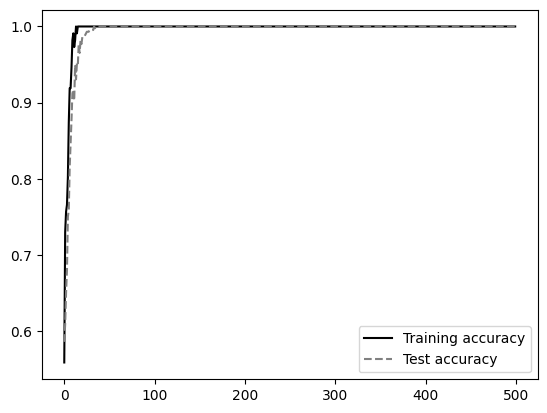

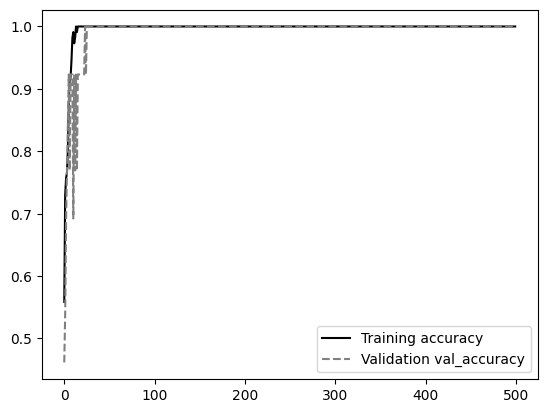

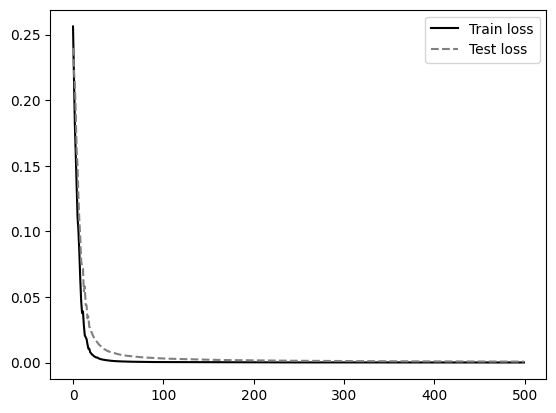

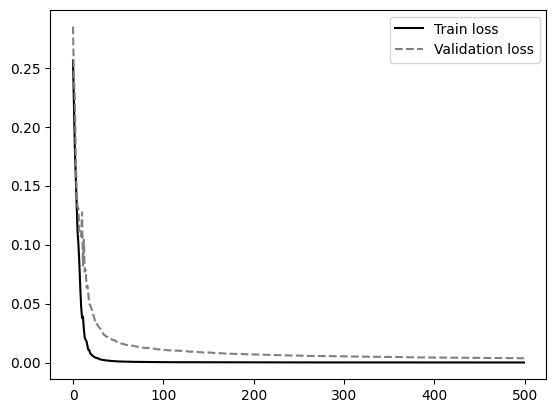

14/14 [==============================] - 0s 2ms/step - loss: 7.1702e-04 - accuracy: 1.0000
[0.0007170165772549808, 1.0]


In [10]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 2

In [11]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [22]:
'''params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.8],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}'''

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


'params = {\n    "task": "classification",\n    "trials_train": 5,\n    "trials_test": 10,\n    "initialization": {\n        "type": "uniform",\n        "min": -0.5,\n        "max": 0.5\n    },\n    "early_stopping": {\n        "monitor": "val_loss",\n        "patience": 20,\n        "delta": 0.00\n    },\n    "max_epochs": [500],\n    "learning_rate": [0.1],\n    "batch_size": [None],\n    "momentum": [0.8],\n    "nesterov": False,\n    "learning_rate_decay": None,\n    "regularization": [\n        {\n            "type": None\n        }\n    ],\n    "layers": [\n        {\n            "activations": ["relu"],\n            "units": [8],\n        },\n    ]\n}'

Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


Fold 1/4 mean val_loss: 0.00021064901375211775, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00012303426046855748, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Fold 2/4 mean val_loss: 0.002444750163704157, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0002999414864461869, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.40s/it]


Fold 3/4 mean val_loss: 0.0010800143936648965, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00010441991616971791, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Fold 4/4 mean val_loss: 0.2634405195713043, std val_loss 0.0
Fold 4/4 mean train_loss: 0.15638864040374756, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.8267716765403748, train_accuracy 0.0

Mean val_loss: 0.06679398328560637, std val_loss: 0.11353672329562335
Mean train_loss: 0.039229009016708005, std train_loss: 0.0676421877592754
Mean val_accuracy: 0.8988095223903656, std val_accuracy: 0.17526704846204766
Mean train_accuracy: 0.8988095223903656, std train_accuracy: 0.07501006438551165



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.99s/it]


Fold 1/4 mean val_loss: 0.0003240454534534365, std val_loss 0.0
Fold 1/4 mean train_loss: 0.00013383042823988944, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.52s/it]


Fold 2/4 mean val_loss: 7.811502291588113e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 7.047226245049387e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.74s/it]


Fold 3/4 mean val_loss: 0.0010913257719948888, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00016076739120762795, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Fold 4/4 mean val_loss: 0.0002833942708093673, std val_loss 0.0
Fold 4/4 mean train_loss: 7.109982107067481e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0004442201297933934, std val_loss: 0.0003850602456766239
Mean train_loss: 0.00010904247574217152, std train_loss: 3.9424661906678706e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.39s/it]


Fold 1/4 mean val_loss: 0.025283344089984894, std val_loss 0.0
Fold 1/4 mean train_loss: 5.077395326225087e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9767441749572754, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Fold 2/4 mean val_loss: 8.932588389143348e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 4.6748522436246276e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.62s/it]


Fold 3/4 mean val_loss: 0.0010975656332448125, std val_loss 0.0
Fold 3/4 mean train_loss: 4.924309178022668e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.66s/it]


Fold 4/4 mean val_loss: 0.00015988880477380008, std val_loss 0.0
Fold 4/4 mean train_loss: 4.536267806543037e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.006657531102973735, std val_loss: 0.010760980446583718
Mean train_loss: 4.803206138603855e-05, std train_loss: 2.1069910550629754e-06
Mean val_accuracy: 0.9941860437393188, std val_accuracy: 0.01007006763648292
Mean train_accuracy: 0.9941860437393188, std train_accuracy: 0.0



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.42s/it]


Fold 1/4 mean val_loss: 2.077919452858623e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 1.7044278138200752e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.00s/it]


Fold 2/4 mean val_loss: 5.5464639444835484e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 1.664279625401832e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.64s/it]


Fold 3/4 mean val_loss: 8.843882096698508e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 3.884391480823979e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Fold 4/4 mean val_loss: 2.6323405108996667e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 2.1511397790163755e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 4.7751515012350865e-05, std val_loss: 2.693333956579716e-05
Mean train_loss: 2.3510596747655654e-05, std train_loss: 9.056591511132379e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Fold 1/4 mean val_loss: 0.00014763551007490605, std val_loss 0.0
Fold 1/4 mean train_loss: 8.619364962214604e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Fold 2/4 mean val_loss: 0.00046520872274413705, std val_loss 0.0
Fold 2/4 mean train_loss: 9.299279190599918e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Fold 3/4 mean val_loss: 0.00017455138731747866, std val_loss 0.0
Fold 3/4 mean train_loss: 8.521351992385462e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Fold 4/4 mean val_loss: 0.00012286279525142163, std val_loss 0.0
Fold 4/4 mean train_loss: 8.35289029055275e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00022756460384698585, std val_loss: 0.00013841627173820267
Mean train_loss: 8.698221608938184e-05, std train_loss: 3.598698264382792e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.41s/it]


Fold 1/4 mean val_loss: 0.0029337957967072725, std val_loss 0.0
Fold 1/4 mean train_loss: 7.019950135145336e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.57s/it]


Fold 2/4 mean val_loss: 0.00019781070295721292, std val_loss 0.0
Fold 2/4 mean train_loss: 6.174042209750041e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Fold 3/4 mean val_loss: 0.0001596924412297085, std val_loss 0.0
Fold 3/4 mean train_loss: 5.506650995812379e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


Fold 4/4 mean val_loss: 0.31342050433158875, std val_loss 0.0
Fold 4/4 mean train_loss: 0.16631878912448883, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.5476190447807312, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.7716535329818726, train_accuracy 0.0

Mean val_loss: 0.07917795081812073, std val_loss: 0.1352446789535241
Mean train_loss: 0.04162644888947398, std train_loss: 0.07199115640030805
Mean val_accuracy: 0.8869047611951828, std val_accuracy: 0.19588669970407865
Mean train_accuracy: 0.8869047611951828, std train_accuracy: 0.0988769206510619



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Fold 1/4 mean val_loss: 0.0004128116415813565, std val_loss 0.0
Fold 1/4 mean train_loss: 8.293226710520685e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Fold 2/4 mean val_loss: 7.670516788493842e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 3.667292548925616e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 3/4 mean val_loss: 9.948226215783507e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 3.4649598092073575e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.94s/it]


Fold 4/4 mean val_loss: 6.733844929840416e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 3.7346992030506954e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016408438023063354, std val_loss: 0.0001440777447253916
Mean train_loss: 4.7900445679260883e-05, std train_loss: 2.0249975726723697e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 1/4 mean val_loss: 0.00018840508710127324, std val_loss 0.0
Fold 1/4 mean train_loss: 1.5145124962145928e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Fold 2/4 mean val_loss: 0.0018112297402694821, std val_loss 0.0
Fold 2/4 mean train_loss: 1.4333474609884433e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 3/4 mean val_loss: 0.023123718798160553, std val_loss 0.0
Fold 3/4 mean train_loss: 0.01578349620103836, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.976190447807312, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9842519760131836, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.99s/it]


Fold 4/4 mean val_loss: 2.6540968974586576e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 1.7564670997671783e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.006287473648626474, std val_loss: 0.009745432591727662
Mean train_loss: 0.003957634867902016, std train_loss: 0.006827664327546956
Mean val_accuracy: 0.994047611951828, std val_accuracy: 0.010309838525799642
Mean train_accuracy: 0.994047611951828, std train_accuracy: 0.006819094415994852



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


Fold 1/4 mean val_loss: 0.0001604324352229014, std val_loss 0.0
Fold 1/4 mean train_loss: 9.87175153568387e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Fold 2/4 mean val_loss: 0.0002469519677106291, std val_loss 0.0
Fold 2/4 mean train_loss: 6.903706525918096e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.25s/it]


Fold 3/4 mean val_loss: 9.56223375396803e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 7.425725198118016e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.34s/it]


Fold 4/4 mean val_loss: 0.0002533608640078455, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00013691648200619966, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00018909190112026408, std val_loss: 6.526141892028107e-05
Mean train_loss: 9.473207865084987e-05, std train_loss: 2.6808859694769527e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Fold 1/4 mean val_loss: 0.0001458411425119266, std val_loss 0.0
Fold 1/4 mean train_loss: 6.657413905486465e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 2/4 mean val_loss: 7.78404573793523e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 4.9478425353299826e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Fold 3/4 mean val_loss: 0.00011457518121460453, std val_loss 0.0
Fold 3/4 mean train_loss: 5.109806079417467e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.86s/it]


Fold 4/4 mean val_loss: 0.00033824151614680886, std val_loss 0.0
Fold 4/4 mean train_loss: 5.227448855293915e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016912457431317307, std val_loss: 0.00010056227486415354
Mean train_loss: 5.485627843881957e-05, std train_loss: 6.837751825451279e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Fold 1/4 mean val_loss: 5.330062049324624e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 2.9194063245086e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.57s/it]


Fold 2/4 mean val_loss: 5.784223321825266e-05, std val_loss 0.0
Fold 2/4 mean train_loss: 3.141400884487666e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.51s/it]


Fold 3/4 mean val_loss: 8.844897092785686e-05, std val_loss 0.0
Fold 3/4 mean train_loss: 4.8845609853742644e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Fold 4/4 mean val_loss: 0.00020263313490431756, std val_loss 0.0
Fold 4/4 mean train_loss: 3.26219160342589e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00010055623988591833, std val_loss: 6.046457307384757e-05
Mean train_loss: 3.551889949449105e-05, std train_loss: 7.791780974131045e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 1/4 mean val_loss: 0.0008139676065184176, std val_loss 0.0
Fold 1/4 mean train_loss: 1.143985991802765e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Fold 2/4 mean val_loss: 0.00012639867782127112, std val_loss 0.0
Fold 2/4 mean train_loss: 1.1705413271556608e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.77s/it]


Fold 3/4 mean val_loss: 0.00010086225665872917, std val_loss 0.0
Fold 3/4 mean train_loss: 3.9821672544348985e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.71s/it]


Fold 4/4 mean val_loss: 2.8844313419540413e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 1.3470609701471403e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0002675182136044896, std val_loss: 0.00031751421267821767
Mean train_loss: 1.9109388858851162e-05, std train_loss: 1.198368739709968e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.41s/it]


Fold 1/4 mean val_loss: 0.00024692073930054903, std val_loss 0.0
Fold 1/4 mean train_loss: 6.74033144605346e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


Fold 2/4 mean val_loss: 0.0007479138439521194, std val_loss 0.0
Fold 2/4 mean train_loss: 0.00016082904767245054, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.28s/it]


Fold 3/4 mean val_loss: 0.00017194893734995276, std val_loss 0.0
Fold 3/4 mean train_loss: 0.00011293307761661708, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Fold 4/4 mean val_loss: 0.00011998241097899154, std val_loss 0.0
Fold 4/4 mean train_loss: 0.00011793507292168215, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00032169148289540317, std val_loss: 0.00025018270563844963
Mean train_loss: 0.0001147751281678211, std train_loss: 3.3084855435445804e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.06s/it]


Fold 1/4 mean val_loss: 7.229102629935369e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 4.389235618873499e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.36s/it]


Fold 2/4 mean val_loss: 0.0006432340014725924, std val_loss 0.0
Fold 2/4 mean train_loss: 4.778798029292375e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Fold 3/4 mean val_loss: 0.0002512551436666399, std val_loss 0.0
Fold 3/4 mean train_loss: 4.5388380385702476e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.39s/it]


Fold 4/4 mean val_loss: 7.809757516952232e-05, std val_loss 0.0
Fold 4/4 mean train_loss: 4.7583638661308214e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00026121943665202707, std val_loss: 0.00023198166698090085
Mean train_loss: 4.616308888216736e-05, std train_loss: 1.6135856028798493e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Fold 1/4 mean val_loss: 0.011859721504151821, std val_loss 0.0
Fold 1/4 mean train_loss: 7.273612573044375e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9767441749572754, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.93s/it]


Fold 2/4 mean val_loss: 0.0005706804804503918, std val_loss 0.0
Fold 2/4 mean train_loss: 2.7446436433820054e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.76s/it]


Fold 3/4 mean val_loss: 0.00018120471213478595, std val_loss 0.0
Fold 3/4 mean train_loss: 3.5915683838538826e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Fold 4/4 mean val_loss: 0.0011466601863503456, std val_loss 0.0
Fold 4/4 mean train_loss: 2.8292597562540323e-05, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.003439566720771836, std val_loss: 0.0048734961319084015
Mean train_loss: 4.109771089133574e-05, std train_loss: 1.8561862242142646e-05
Mean val_accuracy: 0.9941860437393188, std val_accuracy: 0.01007006763648292
Mean train_accuracy: 0.9941860437393188, std train_accuracy: 0.0



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


Fold 1/4 mean val_loss: 2.6345658625359647e-05, std val_loss 0.0
Fold 1/4 mean train_loss: 1.1782658475567587e-05, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Fold 2/4 mean val_loss: 0.027211995795369148, std val_loss 0.0
Fold 2/4 mean train_loss: 2.237413718830794e-05, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9523809552192688, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Fold 3/4 mean val_loss: 0.015913469716906548, std val_loss 0.0
Fold 3/4 mean train_loss: 2.5972878574975766e-05, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.976190447807312, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.80s/it]


Fold 4/4 mean val_loss: 0.0001511310983914882, std val_loss 0.0
Fold 4/4 mean train_loss: 6.658600796072278e-06, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.010825735567323136, std val_loss: 0.01145609625926627
Mean train_loss: 1.6697068758730893e-05, std train_loss: 7.797307566875726e-06
Mean val_accuracy: 0.9821428507566452, std val_accuracy: 0.01974181529804079
Mean train_accuracy: 0.9821428507566452, std train_accuracy: 0.0






Best configuration (loss 4.7751515012350865e-05):
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:54<08:12, 54.68s/it]

Trial 1/10 val_mse: 1.7457190551795065e-05
Trial 1/10 train_mse: 1.3202496120356955e-05
Trial 1/10 test_mse: 0.0007368809310719371
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0
Trial 1/10 test_accuracy: 1.0


 20%|████████▊                                   | 2/10 [01:40<06:37, 49.67s/it]

Trial 2/10 val_mse: 3.60284248017706e-05
Trial 2/10 train_mse: 2.762679650913924e-05
Trial 2/10 test_mse: 2.8053940695826896e-05
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0
Trial 2/10 test_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [02:32<05:54, 50.58s/it]

Trial 3/10 val_mse: 2.4261507860501297e-05
Trial 3/10 train_mse: 1.2943311048729811e-05
Trial 3/10 test_mse: 1.9031424017157406e-05
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0
Trial 3/10 test_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [03:19<04:54, 49.07s/it]

Trial 4/10 val_mse: 1.274927217309596e-05
Trial 4/10 train_mse: 1.4217375792213716e-05
Trial 4/10 test_mse: 1.8837656170944683e-05
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0
Trial 4/10 test_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [04:09<04:06, 49.31s/it]

Trial 5/10 val_mse: 9.701679118734319e-06
Trial 5/10 train_mse: 1.3453064639179502e-05
Trial 5/10 test_mse: 1.8411285054753534e-05
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0
Trial 5/10 test_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [04:56<03:14, 48.70s/it]

Trial 6/10 val_mse: 1.4792920410400257e-05
Trial 6/10 train_mse: 1.5108545994735323e-05
Trial 6/10 test_mse: 7.804882625350729e-05
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0
Trial 6/10 test_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [05:44<02:25, 48.35s/it]

Trial 7/10 val_mse: 1.3946778381068725e-05
Trial 7/10 train_mse: 1.3621121070173103e-05
Trial 7/10 test_mse: 1.9069477275479585e-05
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0
Trial 7/10 test_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [06:31<01:36, 48.04s/it]

Trial 8/10 val_mse: 1.521704689366743e-05
Trial 8/10 train_mse: 1.3029457477387041e-05
Trial 8/10 test_mse: 1.5700059520895593e-05
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0
Trial 8/10 test_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [07:20<00:48, 48.40s/it]

Trial 9/10 val_mse: 2.4691044018254615e-05
Trial 9/10 train_mse: 1.3633706657856237e-05
Trial 9/10 test_mse: 3.886714330292307e-05
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0
Trial 9/10 test_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [08:13<00:00, 49.38s/it]

Trial 10/10 val_mse: 1.3925759049016051e-05
Trial 10/10 train_mse: 1.3034634321229532e-05
Trial 10/10 test_mse: 0.00012463163875509053
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0
Trial 10/10 test_accuracy: 1.0

Median val_mse: 1.521704689366743e-05, std val_mse: 7.456658826770171e-06
Median train_mse: 1.3029457477387041e-05, std train_mse: 4.259417325480304e-06
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 1.0, std train_accuracy: 0.0


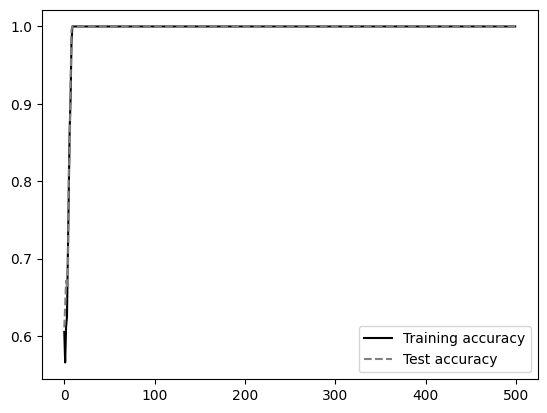

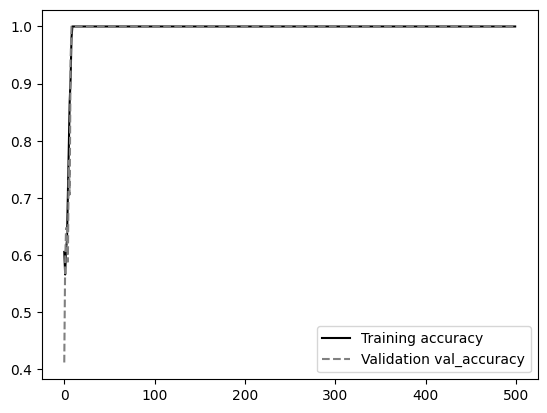

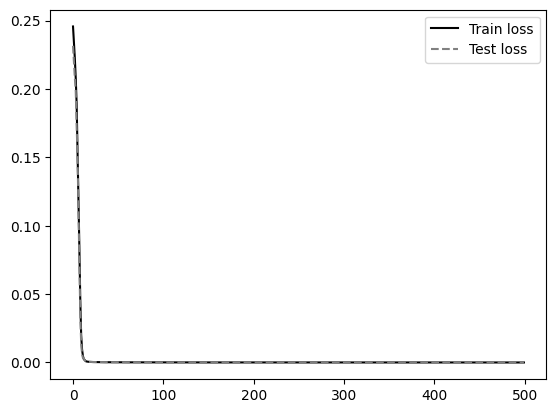

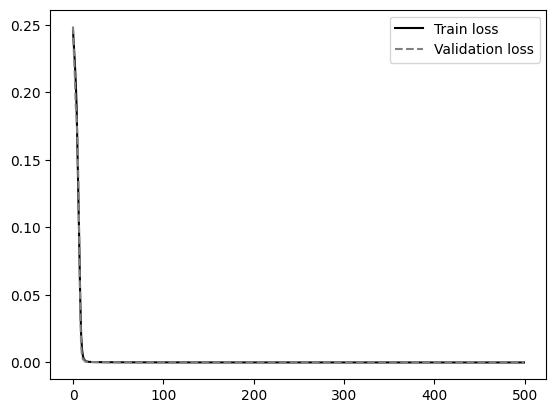

14/14 [==============================] - 0s 2ms/step - loss: 1.5700e-05 - accuracy: 1.0000
[1.5700059520895593e-05, 1.0]


In [12]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)

# Monks 3

In [37]:
'''params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.9, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.5, 0.99, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l2",
            "value": [0.000001, 0.00001, 0.0001, 0.001, 0.01],
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}'''

params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.001, 0.01]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [38]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.42s/it]


Fold 1/4 mean val_loss: 0.0980653464794159, std val_loss 0.0
Fold 1/4 mean train_loss: 0.07161196321249008, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.46s/it]


Fold 2/4 mean val_loss: 0.051134318113327026, std val_loss 0.0
Fold 2/4 mean train_loss: 0.05065196007490158, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Fold 3/4 mean val_loss: 0.07116392254829407, std val_loss 0.0
Fold 3/4 mean train_loss: 0.053661078214645386, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Fold 4/4 mean val_loss: 0.15031829476356506, std val_loss 0.0
Fold 4/4 mean train_loss: 0.052953511476516724, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.09267047047615051, std val_loss: 0.037216125164517416
Mean train_loss: 0.05721962824463844, std train_loss: 0.008383564301802555
Mean val_accuracy: 0.9258064329624176, std val_accuracy: 0.054938763753840894
Mean train_accuracy: 0.9258064329624176, std train_accuracy: 0.014252887708716862



Testing configuration 2/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

E

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


Fold 1/4 mean val_loss: 0.14716856181621552, std val_loss 0.0
Fold 1/4 mean train_loss: 0.15155696868896484, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Fold 2/4 mean val_loss: 0.1950196623802185, std val_loss 0.0
Fold 2/4 mean train_loss: 0.15281923115253448, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Fold 3/4 mean val_loss: 0.164667546749115, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1637546867132187, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Fold 4/4 mean val_loss: 0.13630615174770355, std val_loss 0.0
Fold 4/4 mean train_loss: 0.16215161979198456, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Mean val_loss: 0.16079048067331314, std val_loss: 0.022201956884288786
Mean train_loss: 0.15757062658667564, std train_loss: 0.005430652315285498
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.02244422384099355
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.007479138877258332



Testing configuration 3/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

E

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Fold 1/4 mean val_loss: 0.15101736783981323, std val_loss 0.0
Fold 1/4 mean train_loss: 0.08243675529956818, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Fold 2/4 mean val_loss: 0.18472807109355927, std val_loss 0.0
Fold 2/4 mean train_loss: 0.032957956194877625, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8064516186714172, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Fold 3/4 mean val_loss: 0.11187522858381271, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0671958327293396, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Fold 4/4 mean val_loss: 0.03887432813644409, std val_loss 0.0
Fold 4/4 mean train_loss: 0.05641552060842514, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.12162374891340733, std val_loss: 0.05428775322056213
Mean train_loss: 0.059751516208052635, std train_loss: 0.01802124888797025
Mean val_accuracy: 0.894623652100563, std val_accuracy: 0.07665392564030835
Mean train_accuracy: 0.894623652100563, std train_accuracy: 0.017337954315205927



Testing configuration 4/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Fold 1/4 mean val_loss: 0.19859859347343445, std val_loss 0.0
Fold 1/4 mean train_loss: 0.15802085399627686, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Fold 2/4 mean val_loss: 0.2178647667169571, std val_loss 0.0
Fold 2/4 mean train_loss: 0.15006202459335327, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Fold 3/4 mean val_loss: 0.12392234057188034, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1794320046901703, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9130434989929199, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Fold 4/4 mean val_loss: 0.1457686573266983, std val_loss 0.0
Fold 4/4 mean train_loss: 0.17421531677246094, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Mean val_loss: 0.17153858952224255, std val_loss: 0.03811087468420408
Mean train_loss: 0.16543255001306534, std train_loss: 0.011877584063368621
Mean val_accuracy: 0.9352150410413742, std val_accuracy: 0.05083631013401481
Mean train_accuracy: 0.9352150410413742, std train_accuracy: 0.016941170412276742



Testing configuration 5/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


Fold 1/4 mean val_loss: 0.11432395875453949, std val_loss 0.0
Fold 1/4 mean train_loss: 0.06369490921497345, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Fold 2/4 mean val_loss: 0.11408423632383347, std val_loss 0.0
Fold 2/4 mean train_loss: 0.04218168556690216, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.68s/it]


Fold 3/4 mean val_loss: 0.06897304952144623, std val_loss 0.0
Fold 3/4 mean train_loss: 0.07046578079462051, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Fold 4/4 mean val_loss: 0.09728510677814484, std val_loss 0.0
Fold 4/4 mean train_loss: 0.059443067759275436, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Mean val_loss: 0.098666587844491, std val_loss: 0.01848291005582052
Mean train_loss: 0.05894636083394289, std train_loss: 0.010446851230591523
Mean val_accuracy: 0.9266128838062286, std val_accuracy: 0.02618864773615252
Mean train_accuracy: 0.9266128838062286, std train_accuracy: 0.01625831393806872



Testing configuration 6/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 1/4 mean val_loss: 0.17839406430721283, std val_loss 0.0
Fold 1/4 mean train_loss: 0.16576507687568665, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]


Fold 2/4 mean val_loss: 0.15179789066314697, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17754100263118744, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Fold 3/4 mean val_loss: 0.19193343818187714, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1655309498310089, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/it]


Fold 4/4 mean val_loss: 0.17851518094539642, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1651005893945694, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.17516014352440834, std val_loss: 0.01456753918945708
Mean train_loss: 0.1684844046831131, std train_loss: 0.005234257626151654
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.023963962823384
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.007985636334974604



Testing configuration 7/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execut

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.45s/it]


Fold 1/4 mean val_loss: 0.19232584536075592, std val_loss 0.0
Fold 1/4 mean train_loss: 0.06492827832698822, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


Fold 2/4 mean val_loss: 0.07716363668441772, std val_loss 0.0
Fold 2/4 mean train_loss: 0.04769507423043251, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Fold 3/4 mean val_loss: 0.09240934252738953, std val_loss 0.0
Fold 3/4 mean train_loss: 0.05237797647714615, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Fold 4/4 mean val_loss: 0.1387132704257965, std val_loss 0.0
Fold 4/4 mean train_loss: 0.050926417112350464, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Mean val_loss: 0.12515302374958992, std val_loss: 0.04491992370874281
Mean train_loss: 0.053981936536729336, std train_loss: 0.006543239317665956
Mean val_accuracy: 0.8854838609695435, std val_accuracy: 0.07381663731226129
Mean train_accuracy: 0.8854838609695435, std train_accuracy: 0.009004101721837243



Testing configuration 8/32:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Fold 1/4 mean val_loss: 0.16248229146003723, std val_loss 0.0
Fold 1/4 mean train_loss: 0.18018180131912231, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.17s/it]


Fold 2/4 mean val_loss: 0.21822521090507507, std val_loss 0.0
Fold 2/4 mean train_loss: 0.15759943425655365, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Fold 3/4 mean val_loss: 0.20761826634407043, std val_loss 0.0
Fold 3/4 mean train_loss: 0.19235146045684814, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Fold 4/4 mean val_loss: 0.1738024353981018, std val_loss 0.0
Fold 4/4 mean train_loss: 0.18198129534721375, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.19053205102682114, std val_loss: 0.023051675149265257
Mean train_loss: 0.17802849784493446, std train_loss: 0.012676308818287352
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.03929789926653324
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.013292699743332921



Testing configuration 9/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]


Fold 1/4 mean val_loss: 0.08980643004179001, std val_loss 0.0
Fold 1/4 mean train_loss: 0.06954993307590485, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.83s/it]


Fold 2/4 mean val_loss: 0.12818065285682678, std val_loss 0.0
Fold 2/4 mean train_loss: 0.05374216288328171, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Fold 3/4 mean val_loss: 0.09049909561872482, std val_loss 0.0
Fold 3/4 mean train_loss: 0.07123595476150513, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


Fold 4/4 mean val_loss: 0.10791034996509552, std val_loss 0.0
Fold 4/4 mean train_loss: 0.051592931151390076, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Mean val_loss: 0.10409913212060928, std val_loss: 0.015681895197914363
Mean train_loss: 0.06153024546802044, std train_loss: 0.008915164445930138
Mean val_accuracy: 0.9263440668582916, std val_accuracy: 0.027101255460222656
Mean train_accuracy: 0.9263440668582916, std train_accuracy: 0.01639485439524136



Testing configuration 10/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

E

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.14s/it]


Fold 1/4 mean val_loss: 0.19163239002227783, std val_loss 0.0
Fold 1/4 mean train_loss: 0.15992221236228943, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Fold 2/4 mean val_loss: 0.1815580427646637, std val_loss 0.0
Fold 2/4 mean train_loss: 0.16447234153747559, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Fold 3/4 mean val_loss: 0.15608535706996918, std val_loss 0.0
Fold 3/4 mean train_loss: 0.16737081110477448, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


Fold 4/4 mean val_loss: 0.16640068590641022, std val_loss 0.0
Fold 4/4 mean train_loss: 0.16470004618167877, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.17391911894083023, std val_loss: 0.01366275070539251
Mean train_loss: 0.16411635279655457, std train_loss: 0.0026762725390820923
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.02244422384099355
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.007479138877258332



Testing configuration 11/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.26s/it]


Fold 1/4 mean val_loss: 0.099857859313488, std val_loss 0.0
Fold 1/4 mean train_loss: 0.055076614022254944, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979553, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Fold 2/4 mean val_loss: 0.0976448804140091, std val_loss 0.0
Fold 2/4 mean train_loss: 0.05538757145404816, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Fold 3/4 mean val_loss: 0.09895281493663788, std val_loss 0.0
Fold 3/4 mean train_loss: 0.045191459357738495, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


Fold 4/4 mean val_loss: 0.07222864776849747, std val_loss 0.0
Fold 4/4 mean train_loss: 0.05036943033337593, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Mean val_loss: 0.09217105060815811, std val_loss: 0.011540597896579099
Mean train_loss: 0.05150626879185438, std train_loss: 0.004152742927562191
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.02244422384099355
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.009165663660982292



Testing configuration 12/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Fold 1/4 mean val_loss: 0.15164358913898468, std val_loss 0.0
Fold 1/4 mean train_loss: 0.15417633950710297, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.62s/it]


Fold 2/4 mean val_loss: 0.1899031698703766, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17539358139038086, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.47s/it]


Fold 3/4 mean val_loss: 0.15249791741371155, std val_loss 0.0
Fold 3/4 mean train_loss: 0.15514375269412994, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]


Fold 4/4 mean val_loss: 0.18397024273872375, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1707114279270172, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.16950372979044914, std val_loss: 0.01756131708571457
Mean train_loss: 0.16385627537965775, std train_loss: 0.009350290857444571
Mean val_accuracy: 0.9344086050987244, std val_accuracy: 0.0010752677917480469
Mean train_accuracy: 0.9344086050987244, std train_accuracy: 0.00035834312438964844



Testing configuration 13/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


Fold 1/4 mean val_loss: 0.12272214889526367, std val_loss 0.0
Fold 1/4 mean train_loss: 0.05005661025643349, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]


Fold 2/4 mean val_loss: 0.17486757040023804, std val_loss 0.0
Fold 2/4 mean train_loss: 0.05030117928981781, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Fold 3/4 mean val_loss: 0.07146169245243073, std val_loss 0.0
Fold 3/4 mean train_loss: 0.053164903074502945, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]


Fold 4/4 mean val_loss: 0.06691892445087433, std val_loss 0.0
Fold 4/4 mean train_loss: 0.0672995075583458, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.10899258404970169, std val_loss: 0.043894121000584874
Mean train_loss: 0.05520555004477501, std train_loss: 0.007088590865668961
Mean val_accuracy: 0.8946236371994019, std val_accuracy: 0.07975493906562248
Mean train_accuracy: 0.8946236371994019, std train_accuracy: 0.014201586615055994



Testing configuration 14/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.14s/it]


Fold 1/4 mean val_loss: 0.22093190252780914, std val_loss 0.0
Fold 1/4 mean train_loss: 0.15978027880191803, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


Fold 2/4 mean val_loss: 0.1884649395942688, std val_loss 0.0
Fold 2/4 mean train_loss: 0.18454259634017944, std train_loss 0.0
Fold 2/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9120879173278809, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Fold 3/4 mean val_loss: 0.1953427791595459, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1781829595565796, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9130434989929199, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Fold 4/4 mean val_loss: 0.1699044108390808, std val_loss 0.0
Fold 4/4 mean train_loss: 0.171805739402771, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.19366100803017616, std val_loss: 0.01828869239532451
Mean train_loss: 0.17357789352536201, std train_loss: 0.009150765586276836
Mean val_accuracy: 0.9344086050987244, std val_accuracy: 0.04563246135625747
Mean train_accuracy: 0.9344086050987244, std train_accuracy: 0.018065453682744537



Testing configuration 15/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Fold 1/4 mean val_loss: 0.04012898728251457, std val_loss 0.0
Fold 1/4 mean train_loss: 0.04756617173552513, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Fold 2/4 mean val_loss: 0.12551948428153992, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0770391896367073, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]


Fold 3/4 mean val_loss: 0.15484577417373657, std val_loss 0.0
Fold 3/4 mean train_loss: 0.04802999645471573, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 4/4 mean val_loss: 0.12601397931575775, std val_loss 0.0
Fold 4/4 mean train_loss: 0.049748629331588745, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Mean val_loss: 0.1116270562633872, std val_loss: 0.04295292352379044
Mean train_loss: 0.05559599678963423, std train_loss: 0.012406900067439896
Mean val_accuracy: 0.9174731075763702, std val_accuracy: 0.04975007105871574
Mean train_accuracy: 0.9174731075763702, std train_accuracy: 0.02114898566361997



Testing configuration 16/32:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 1/4 mean val_loss: 0.16016031801700592, std val_loss 0.0
Fold 1/4 mean train_loss: 0.18675604462623596, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]


Fold 2/4 mean val_loss: 0.22174569964408875, std val_loss 0.0
Fold 2/4 mean train_loss: 0.15695592761039734, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


Fold 3/4 mean val_loss: 0.20877660810947418, std val_loss 0.0
Fold 3/4 mean train_loss: 0.17047303915023804, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Fold 4/4 mean val_loss: 0.14710739254951477, std val_loss 0.0
Fold 4/4 mean train_loss: 0.20688873529434204, std train_loss 0.0
Fold 4/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9130434989929199, train_accuracy 0.0

Mean val_loss: 0.1844475045800209, std val_loss: 0.03149290408640316
Mean train_loss: 0.18026843667030334, std train_loss: 0.01864237275045198
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.051530931088324315
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.017171000499226576



Testing configuration 17/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Fold 1/4 mean val_loss: 0.14896294474601746, std val_loss 0.0
Fold 1/4 mean train_loss: 0.04653485119342804, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.74s/it]


Fold 2/4 mean val_loss: 0.07034771144390106, std val_loss 0.0
Fold 2/4 mean train_loss: 0.0650591030716896, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.95s/it]


Fold 3/4 mean val_loss: 0.11584413051605225, std val_loss 0.0
Fold 3/4 mean train_loss: 0.05675220862030983, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


Fold 4/4 mean val_loss: 0.08603490889072418, std val_loss 0.0
Fold 4/4 mean train_loss: 0.06777843087911606, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.10529742389917374, std val_loss: 0.03004345859103791
Mean train_loss: 0.05903114844113588, std train_loss: 0.008279525932802973
Mean val_accuracy: 0.9016128778457642, std val_accuracy: 0.04564829438719802
Mean train_accuracy: 0.9016128778457642, std train_accuracy: 0.020319187333778067



Testing configuration 18/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Fold 1/4 mean val_loss: 0.15596631169319153, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1851838082075119, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Fold 2/4 mean val_loss: 0.16821494698524475, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17491191625595093, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.46s/it]


Fold 3/4 mean val_loss: 0.24003513157367706, std val_loss 0.0
Fold 3/4 mean train_loss: 0.14415358006954193, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.21s/it]


Fold 4/4 mean val_loss: 0.15503671765327454, std val_loss 0.0
Fold 4/4 mean train_loss: 0.17583274841308594, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Mean val_loss: 0.17981327697634697, std val_loss: 0.03515589806430145
Mean train_loss: 0.17002051323652267, std train_loss: 0.015465539491789696
Mean val_accuracy: 0.933870941400528, std val_accuracy: 0.058047086436475076
Mean train_accuracy: 0.933870941400528, std train_accuracy: 0.019071060941668563



Testing configuration 19/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Fold 1/4 mean val_loss: 0.06620621681213379, std val_loss 0.0
Fold 1/4 mean train_loss: 0.05054854229092598, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/it]


Fold 2/4 mean val_loss: 0.09023430198431015, std val_loss 0.0
Fold 2/4 mean train_loss: 0.05967695266008377, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979553, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


Fold 3/4 mean val_loss: 0.13477914035320282, std val_loss 0.0
Fold 3/4 mean train_loss: 0.05945350229740143, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]


Fold 4/4 mean val_loss: 0.15108990669250488, std val_loss 0.0
Fold 4/4 mean train_loss: 0.039734747260808945, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.11057739146053791, std val_loss: 0.03394713157617648
Mean train_loss: 0.05235343612730503, std train_loss: 0.008162931221314777
Mean val_accuracy: 0.8927419185638428, std val_accuracy: 0.04986033057329237
Mean train_accuracy: 0.8927419185638428, std train_accuracy: 0.012259785068184674



Testing configuration 20/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Fold 1/4 mean val_loss: 0.1507624089717865, std val_loss 0.0
Fold 1/4 mean train_loss: 0.18132534623146057, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Fold 2/4 mean val_loss: 0.2174348384141922, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17389051616191864, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 3/4 mean val_loss: 0.1415603905916214, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1846795231103897, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9130434989929199, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Fold 4/4 mean val_loss: 0.22170928120613098, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1507369726896286, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.18286672979593277, std val_loss: 0.03688020813234049
Mean train_loss: 0.17265808954834938, std train_loss: 0.013244720108301754
Mean val_accuracy: 0.9344085901975632, std val_accuracy: 0.0523800482840843
Mean train_accuracy: 0.9344085901975632, std train_accuracy: 0.016156555993530736



Testing configuration 21/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Fold 1/4 mean val_loss: 0.11246646195650101, std val_loss 0.0
Fold 1/4 mean train_loss: 0.051666758954524994, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.08s/it]


Fold 2/4 mean val_loss: 0.09148328006267548, std val_loss 0.0
Fold 2/4 mean train_loss: 0.051637325435876846, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Fold 3/4 mean val_loss: 0.12674014270305634, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0578380785882473, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Fold 4/4 mean val_loss: 0.10761134326457977, std val_loss 0.0
Fold 4/4 mean train_loss: 0.07787512987852097, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.10957530699670315, std val_loss: 0.01259135570491061
Mean train_loss: 0.059754323214292526, std train_loss: 0.010762550536697462
Mean val_accuracy: 0.8852150440216064, std val_accuracy: 0.01650763707196155
Mean train_accuracy: 0.8852150440216064, std train_accuracy: 0.024697608922615886



Testing configuration 22/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

E

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


Fold 1/4 mean val_loss: 0.19125637412071228, std val_loss 0.0
Fold 1/4 mean train_loss: 0.18906527757644653, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Fold 2/4 mean val_loss: 0.1962883025407791, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17140567302703857, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


Fold 3/4 mean val_loss: 0.16299445927143097, std val_loss 0.0
Fold 3/4 mean train_loss: 0.16702009737491608, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Fold 4/4 mean val_loss: 0.19990292191505432, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1762998402118683, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.18761051446199417, std val_loss: 0.014540028823288767
Mean train_loss: 0.17594772204756737, std train_loss: 0.00825419502216112
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.023963962823384
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.007985636334974604



Testing configuration 23/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


Fold 1/4 mean val_loss: 0.14483068883419037, std val_loss 0.0
Fold 1/4 mean train_loss: 0.05649439990520477, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Fold 2/4 mean val_loss: 0.13663333654403687, std val_loss 0.0
Fold 2/4 mean train_loss: 0.04963061213493347, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Fold 3/4 mean val_loss: 0.11926323920488358, std val_loss 0.0
Fold 3/4 mean train_loss: 0.06190335750579834, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.967391312122345, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.53s/it]


Fold 4/4 mean val_loss: 0.12318877875804901, std val_loss 0.0
Fold 4/4 mean train_loss: 0.04477190971374512, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.13097901083528996, std val_loss: 0.010268731705022372
Mean train_loss: 0.053200069814920425, std train_loss: 0.006526383726731848
Mean val_accuracy: 0.8774193376302719, std val_accuracy: 0.025297397291137405
Mean train_accuracy: 0.8774193376302719, std train_accuracy: 0.011872803693511638



Testing configuration 24/32:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Executing fold

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.48s/it]


Fold 1/4 mean val_loss: 0.16213048994541168, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1988854855298996, std train_loss 0.0
Fold 1/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9120879173278809, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Fold 2/4 mean val_loss: 0.18756824731826782, std val_loss 0.0
Fold 2/4 mean train_loss: 0.16349275410175323, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Fold 3/4 mean val_loss: 0.24431751668453217, std val_loss 0.0
Fold 3/4 mean train_loss: 0.17169024050235748, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8666666746139526, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.84s/it]


Fold 4/4 mean val_loss: 0.17821231484413147, std val_loss 0.0
Fold 4/4 mean train_loss: 0.20677973330020905, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9130434989929199, train_accuracy 0.0

Mean val_loss: 0.19305714219808578, std val_loss: 0.030961995568030483
Mean train_loss: 0.18521205335855484, std train_loss: 0.018074117879820068
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.052210775948213814
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.01953951508336837



Testing configuration 25/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}



100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]


Fold 1/4 mean val_loss: 0.06820850819349289, std val_loss 0.0
Fold 1/4 mean train_loss: 0.058248426765203476, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979553, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


Fold 2/4 mean val_loss: 0.1008293479681015, std val_loss 0.0
Fold 2/4 mean train_loss: 0.057314541190862656, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]


Fold 3/4 mean val_loss: 0.12702202796936035, std val_loss 0.0
Fold 3/4 mean train_loss: 0.06356962770223618, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.15s/it]


Fold 4/4 mean val_loss: 0.09592930227518082, std val_loss 0.0
Fold 4/4 mean train_loss: 0.04989566653966904, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Mean val_loss: 0.09799729660153389, std val_loss: 0.02086926005678108
Mean train_loss: 0.057257065549492836, std train_loss: 0.004874031617240716
Mean val_accuracy: 0.9177419245243073, std val_accuracy: 0.01774194836616516
Mean train_accuracy: 0.9177419245243073, std train_accuracy: 0.018025724083849334



Testing configuration 26/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Ex

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Fold 1/4 mean val_loss: 0.1771712303161621, std val_loss 0.0
Fold 1/4 mean train_loss: 0.1695387214422226, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.38s/it]


Fold 2/4 mean val_loss: 0.17853352427482605, std val_loss 0.0
Fold 2/4 mean train_loss: 0.17072933912277222, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Fold 3/4 mean val_loss: 0.17673368752002716, std val_loss 0.0
Fold 3/4 mean train_loss: 0.17943312227725983, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Fold 4/4 mean val_loss: 0.17943215370178223, std val_loss 0.0
Fold 4/4 mean train_loss: 0.16740582883358002, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.1779676489531994, std val_loss: 0.0010749340098611328
Mean train_loss: 0.17177675291895866, std train_loss: 0.004577958870014541
Mean val_accuracy: 0.9344086050987244, std val_accuracy: 0.0010752677917480469
Mean train_accuracy: 0.9344086050987244, std train_accuracy: 0.00035834312438964844



Testing configuration 27/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Fold 1/4 mean val_loss: 0.13275811076164246, std val_loss 0.0
Fold 1/4 mean train_loss: 0.03448250889778137, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]


Fold 2/4 mean val_loss: 0.101935014128685, std val_loss 0.0
Fold 2/4 mean train_loss: 0.06722640246152878, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


Fold 3/4 mean val_loss: 0.0613277293741703, std val_loss 0.0
Fold 3/4 mean train_loss: 0.0640496239066124, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.30s/it]


Fold 4/4 mean val_loss: 0.08015571534633636, std val_loss 0.0
Fold 4/4 mean train_loss: 0.057411182671785355, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Mean val_loss: 0.09404414240270853, std val_loss: 0.026572021424077
Mean train_loss: 0.055792429484426975, std train_loss: 0.012802832450844513
Mean val_accuracy: 0.9266128838062286, std val_accuracy: 0.02618864773615252
Mean train_accuracy: 0.9266128838062286, std train_accuracy: 0.01652371517324221



Testing configuration 28/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.09s/it]


Fold 1/4 mean val_loss: 0.20390790700912476, std val_loss 0.0
Fold 1/4 mean train_loss: 0.177407905459404, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9120879173278809, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.88s/it]


Fold 2/4 mean val_loss: 0.19808705151081085, std val_loss 0.0
Fold 2/4 mean train_loss: 0.18188528716564178, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Fold 3/4 mean val_loss: 0.15945066511631012, std val_loss 0.0
Fold 3/4 mean train_loss: 0.1833048015832901, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9239130616188049, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.58s/it]


Fold 4/4 mean val_loss: 0.15972468256950378, std val_loss 0.0
Fold 4/4 mean train_loss: 0.15894238650798798, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.18029257655143738, std val_loss: 0.020807154459628156
Mean train_loss: 0.17538509517908096, std train_loss: 0.009739464503549948
Mean val_accuracy: 0.9346774071455002, std val_accuracy: 0.02244422384099355
Mean train_accuracy: 0.9346774071455002, std train_accuracy: 0.012278935978248523



Testing configuration 29/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}



100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.49s/it]


Fold 1/4 mean val_loss: 0.1402498334646225, std val_loss 0.0
Fold 1/4 mean train_loss: 0.03796010836958885, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9890109896659851, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Fold 2/4 mean val_loss: 0.1068849265575409, std val_loss 0.0
Fold 2/4 mean train_loss: 0.06405191123485565, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9670329689979553, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Fold 3/4 mean val_loss: 0.05262153595685959, std val_loss 0.0
Fold 3/4 mean train_loss: 0.04571092501282692, std train_loss 0.0
Fold 3/4 mean val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


Fold 4/4 mean val_loss: 0.07587435841560364, std val_loss 0.0
Fold 4/4 mean train_loss: 0.05638327822089195, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.989130437374115, train_accuracy 0.0

Mean val_loss: 0.09390766359865665, std val_loss: 0.03296115324616976
Mean train_loss: 0.051026555709540844, std train_loss: 0.00996672386514308
Mean val_accuracy: 0.9432795643806458, std val_accuracy: 0.04757608376102686
Mean train_accuracy: 0.9432795643806458, std train_accuracy: 0.00955136817838501



Testing configuration 30/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Exec

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


Fold 1/4 mean val_loss: 0.15282051265239716, std val_loss 0.0
Fold 1/4 mean train_loss: 0.187236949801445, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Fold 2/4 mean val_loss: 0.16440017521381378, std val_loss 0.0
Fold 2/4 mean train_loss: 0.16190922260284424, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]


Fold 3/4 mean val_loss: 0.2034107744693756, std val_loss 0.0
Fold 3/4 mean train_loss: 0.17325778305530548, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


Fold 4/4 mean val_loss: 0.19874978065490723, std val_loss 0.0
Fold 4/4 mean train_loss: 0.1746518313884735, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.17984531074762344, std val_loss: 0.021688718188508236
Mean train_loss: 0.17426394671201706, std train_loss: 0.00897358396626454
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.023963962823384
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.007985636334974604



Testing configuration 31/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Execu

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]


Fold 1/4 mean val_loss: 0.0558064728975296, std val_loss 0.0
Fold 1/4 mean train_loss: 0.07761281728744507, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9670329689979553, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Fold 2/4 mean val_loss: 0.12954367697238922, std val_loss 0.0
Fold 2/4 mean train_loss: 0.04370099678635597, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9780219793319702, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Fold 3/4 mean val_loss: 0.2136872112751007, std val_loss 0.0
Fold 3/4 mean train_loss: 0.05568774789571762, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.97826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.41s/it]


Fold 4/4 mean val_loss: 0.07839858531951904, std val_loss 0.0
Fold 4/4 mean train_loss: 0.06792902946472168, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.95652174949646, train_accuracy 0.0

Mean val_loss: 0.11935898661613464, std val_loss: 0.06065933225666606
Mean train_loss: 0.061232647858560085, std train_loss: 0.012759860716811955
Mean val_accuracy: 0.9013440757989883, std val_accuracy: 0.07047880868241445
Mean train_accuracy: 0.9013440757989883, std train_accuracy: 0.008986853147023202



Testing configuration 32/32:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}

Exe

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Fold 1/4 mean val_loss: 0.22858424484729767, std val_loss 0.0
Fold 1/4 mean train_loss: 0.176816925406456, std train_loss 0.0
Fold 1/4 mean val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 mean train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Fold 2/4 mean val_loss: 0.17467816174030304, std val_loss 0.0
Fold 2/4 mean train_loss: 0.20613738894462585, std train_loss 0.0
Fold 2/4 mean val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 mean train_accuracy: 0.9230769276618958, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Fold 3/4 mean val_loss: 0.18591457605361938, std val_loss 0.0
Fold 3/4 mean train_loss: 0.18145906925201416, std train_loss 0.0
Fold 3/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 3/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Fold 4/4 mean val_loss: 0.1823214739561081, std val_loss 0.0
Fold 4/4 mean train_loss: 0.18739689886569977, std train_loss 0.0
Fold 4/4 mean val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 mean train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.19287461414933205, std val_loss: 0.021012493325940382
Mean train_loss: 0.18795257061719894, std train_loss: 0.011148593441956421
Mean val_accuracy: 0.9344085901975632, std val_accuracy: 0.022835225002839483
Mean train_accuracy: 0.9344085901975632, std train_accuracy: 0.007778662086460652






Best configuration (loss 0.09217105060815811):
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 're

 10%|████▍                                       | 1/10 [00:06<00:58,  6.47s/it]

Trial 1/10 val_mse: 0.1438526213169098
Trial 1/10 train_mse: 0.05282866209745407
Trial 1/10 val_accuracy: 0.9230769276618958
Trial 1/10 train_accuracy: 0.9816513657569885


 20%|████████▊                                   | 2/10 [00:12<00:49,  6.14s/it]

Trial 2/10 val_mse: 0.1412692666053772
Trial 2/10 train_mse: 0.05283910781145096
Trial 2/10 val_accuracy: 0.9230769276618958
Trial 2/10 train_accuracy: 0.9816513657569885


 30%|█████████████▏                              | 3/10 [00:21<00:52,  7.45s/it]

Trial 3/10 val_mse: 0.13985450565814972
Trial 3/10 train_mse: 0.04431547969579697
Trial 3/10 val_accuracy: 0.9230769276618958
Trial 3/10 train_accuracy: 0.9908257126808167


 40%|█████████████████▌                          | 4/10 [00:27<00:41,  6.87s/it]

Trial 4/10 val_mse: 0.14453113079071045
Trial 4/10 train_mse: 0.05232527107000351
Trial 4/10 val_accuracy: 0.9230769276618958
Trial 4/10 train_accuracy: 0.9724770784378052


 50%|██████████████████████                      | 5/10 [00:35<00:36,  7.32s/it]

Trial 5/10 val_mse: 0.13728295266628265
Trial 5/10 train_mse: 0.04378686100244522
Trial 5/10 val_accuracy: 0.8461538553237915
Trial 5/10 train_accuracy: 0.9816513657569885


 60%|██████████████████████████▍                 | 6/10 [00:40<00:26,  6.67s/it]

Trial 6/10 val_mse: 0.15076227486133575
Trial 6/10 train_mse: 0.06519515067338943
Trial 6/10 val_accuracy: 0.8461538553237915
Trial 6/10 train_accuracy: 0.963302731513977


 70%|██████████████████████████████▊             | 7/10 [00:48<00:20,  6.86s/it]

Trial 7/10 val_mse: 0.13125330209732056
Trial 7/10 train_mse: 0.04893779009580612
Trial 7/10 val_accuracy: 0.9230769276618958
Trial 7/10 train_accuracy: 0.9908257126808167


 80%|███████████████████████████████████▏        | 8/10 [00:53<00:12,  6.30s/it]

Trial 8/10 val_mse: 0.14856597781181335
Trial 8/10 train_mse: 0.06290347129106522
Trial 8/10 val_accuracy: 0.9230769276618958
Trial 8/10 train_accuracy: 0.9724770784378052


 90%|███████████████████████████████████████▌    | 9/10 [01:01<00:07,  7.02s/it]

Trial 9/10 val_mse: 0.12910246849060059
Trial 9/10 train_mse: 0.041202906519174576
Trial 9/10 val_accuracy: 0.9230769276618958
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [01:06<00:00,  6.67s/it]

Trial 10/10 val_mse: 0.1404014676809311
Trial 10/10 train_mse: 0.055942051112651825
Trial 10/10 val_accuracy: 0.9230769276618958
Trial 10/10 train_accuracy: 0.9816513657569885

Median val_mse: 0.1412692666053772, std val_mse: 0.006513717262689968
Median train_mse: 0.05283910781145096, std train_mse: 0.007499921606397769
Median val_accuracy: 0.9230769276618958, std val_accuracy: 0.0307692289352417
Median train_accuracy: 0.9816513657569885, std train_accuracy: 0.010049960874319717


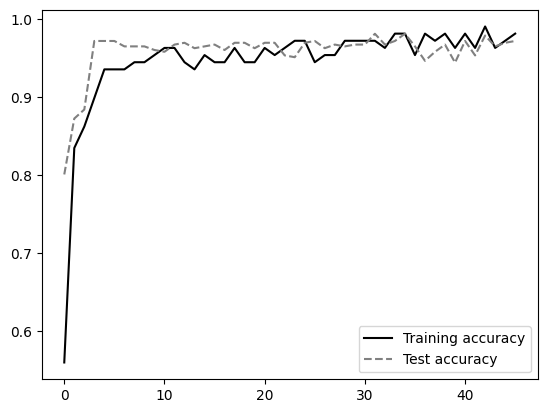

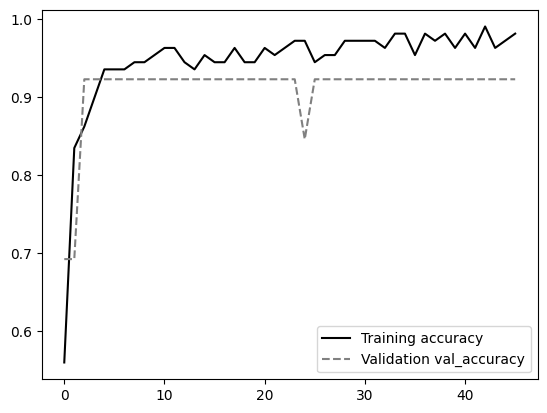

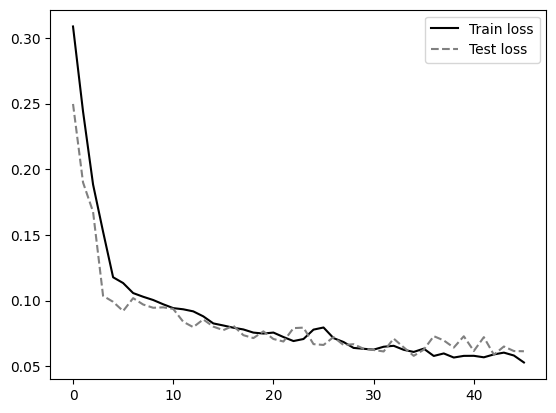

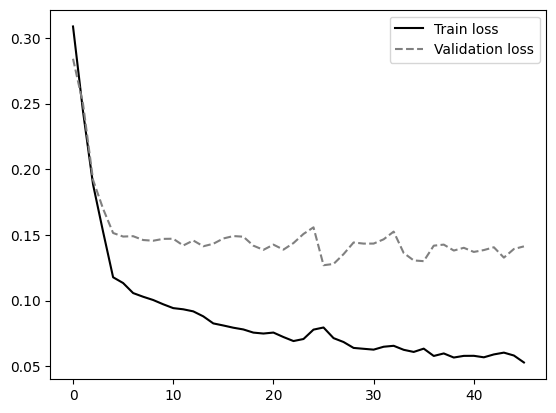

14/14 [==============================] - 0s 1ms/step - loss: 0.0614 - accuracy: 0.9722
[0.061380982398986816, 0.9722222089767456]


In [39]:
model = grid_search(params, x_train, y_train, x_test, y_test, k_fold_val)
test_model(model, x_test, y_test)